In [27]:
from scripts.mrs_ue_utils import generate_dem
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os
from skimage.restoration import unwrap_phase
import scienceplots

# Exercise 4: **InSAR Measurement Simulation**

This exercise simulates the actual measurement of the phases based on a given Digital Elevation Model (DEM). First, download or use the Python file:
”∼/shared/mrs22w/scripts/mrs ue utils.py” at the JupyterHub server and put it into the same directory as your Jupyter Notebook script.
Import the `generate_dem()` function at the beginning of your script and generate 3D coordinates with it:
`from mrs_ue_utils import generate_dem` and
`x, y, z = generate_dem ()`
Two C-band SAR sensors observe the region of interest (defined by the generated DEM) at 5 cm wavelength. The master sensor position is located at $p_m$ and is separated by a baseline $b$ into the direction $\vec{b}_e$ from the slave sensor position ps (all units in m):

$ p_m = \begin{bmatrix}0\\ -12000\\ 10000 \end{bmatrix}$

$ \vec{b}\_e = \begin{bmatrix}0.5\\ 0.5\\ 0 \end{bmatrix}$

$b = 100$

Use the generated DEM and the sensor positions to create a master and a slave phase image.
_Hint: derive relative phase values $\phi \in [0,2\pi]$ from the computed distances between the sensors and terrain points_


## 4.1 What kind of baselines exist?

-   Single-pass-interferometry involves both antennas being on the same platform, requiring only a single overflight. In the first mode, one antenna transmits while both receive, creating a temporal baseline between the signals. In the second mode, the transmitted signal alternates between antennas, resulting in coherent signals
-   Dual- and multi-pass-interferometry exhibit an extended temporal baseline as the second signal is transmitted and received during a subsequent flight pass with a temporal shift

In passive MRS, only single-pass-interferometry is feasible since thermal radiation remains coherent for a very brief time-scale.


## 4.2 What does the term decorrelation mean in terms of InSAR?

Decorrelation, in the context of InSAR, denotes the reduction of signal coherence, which may be induced by heterogeneity, thermal noise from the system, or other sources of errors. When coherence falls below 0.3, the quality of phase measurements becomes severely compromised and renders them unusable.


## 4.3 Name some terms of decorrelation.

-   Baseline or geometric $\gamma_{geom}$: Arises from variations in incidence angles between two acquisitions.
-   Doppler centroids $\gamma_{DC}$: Caused, for instance, by the Earth's rotation.
-   Volume $\gamma_{vol}$: Occurs due to penetration into a medium.
-   Thermal $\gamma_{thermal}$: Arises from the thermal effects of the SAR system.
-   Temporal-terrain $\gamma_{temporal}$: Results from physical changes in the terrain, especially significant when the temporal baseline increases.
-   Processing $\gamma_{proc}$: Emerges as a consequence of the chosen algorithms in the processing stage.

$\Rightarrow \gamma_{tot} = \prod_n^N \gamma_n$


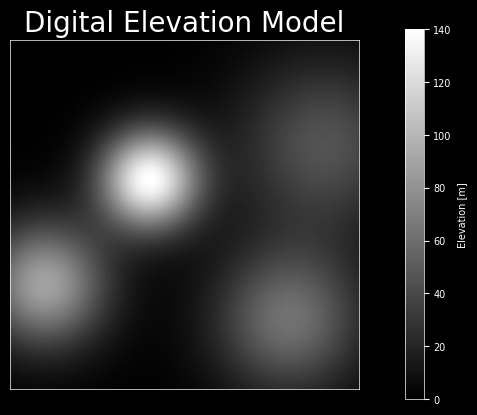

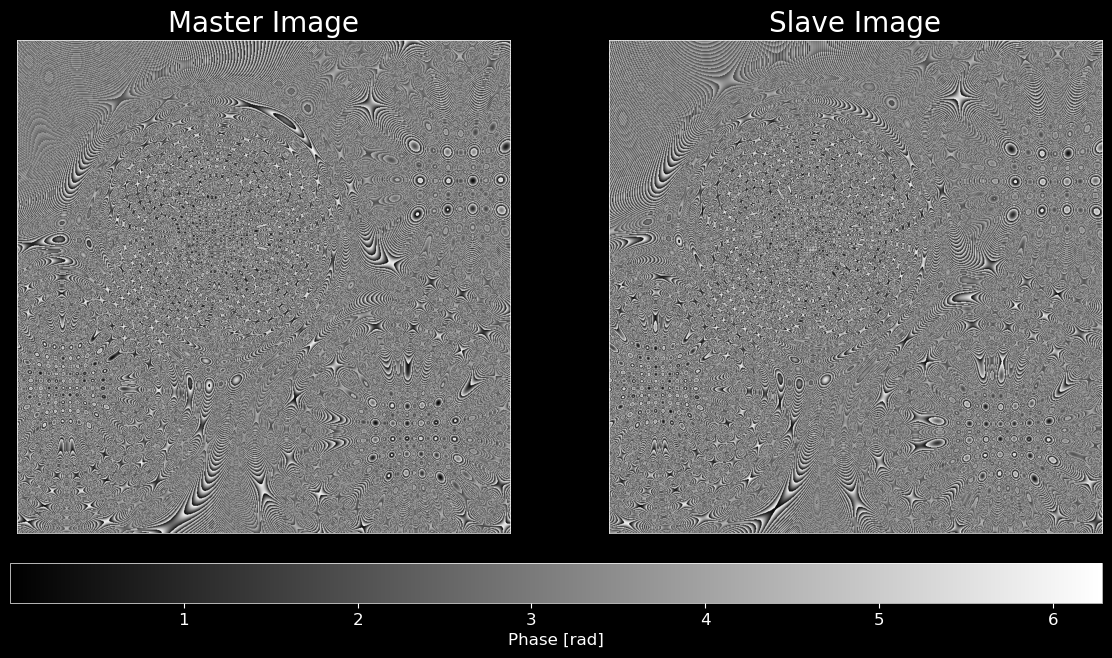

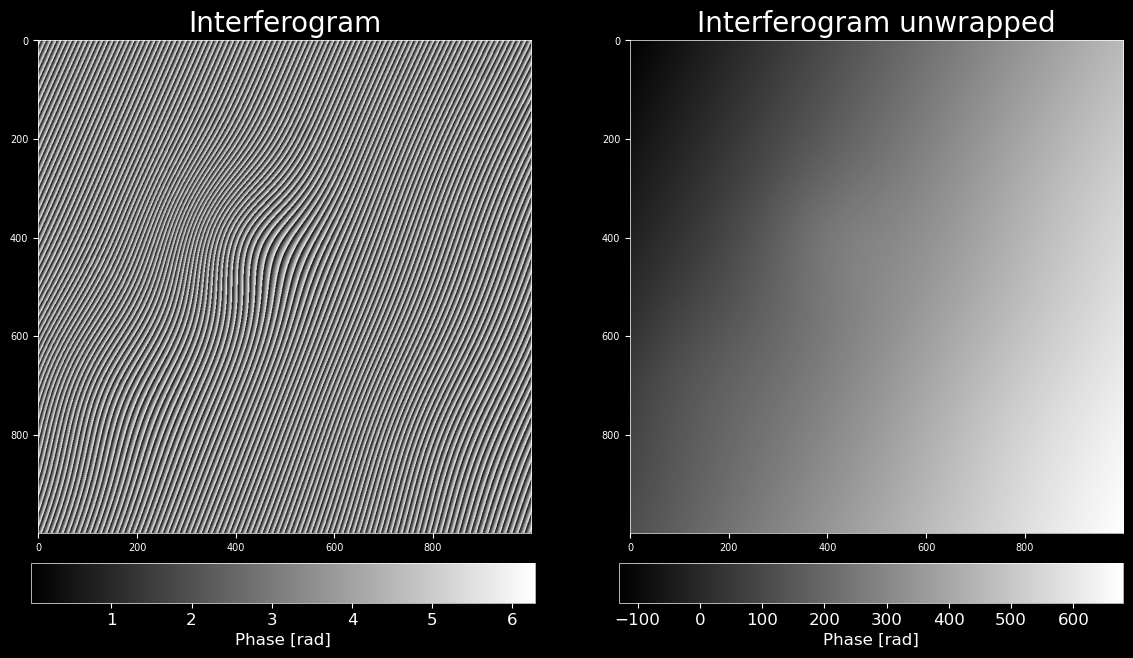

In [30]:
def angle(v, w):
    return np.arccos(v.dot(w) / (norm(v) * norm(w)))


x, y, z = generate_dem()
dem = np.dstack((x, y, z))

# Position master
p_m = np.array([0., -12_000., 10_000.])
p_c = np.array([np.sqrt(0.5), np.sqrt(0.5), 0.])
b = 100.

p_m = p_m.astype(np.longdouble)
p_c = p_c.astype(np.longdouble)
dem = dem.astype(np.longdouble)

p_s = p_m - (p_c * b)

baseline = (p_c * b)

lambda_ = 0.05

k = 2 * np.pi / lambda_

R1 = dem - p_m
R2 = R1 - baseline

with plt.style.context('nature'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    im = ax.imshow(z, cmap='grey')
    cbar = fig.colorbar(im, ax=ax, pad=0.1, shrink=0.8, label='Elevation [m]')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Digital Elevation Model', fontsize=20)

master = norm(R1, axis=2) * k % (2 * np.pi)
slave = norm(R2, axis=2) * k % (2 * np.pi)
interferogram = (master - slave) % (2 * np.pi)

unwrapped_phases = unwrap_phase(interferogram)
with plt.style.context('nature'):
    fig, ax = plt.subplots(1, 2, figsize=(14, 8))

    ax[0].imshow(master, cmap='grey')
    ax[1].imshow(slave, cmap='grey')
    ax[0].set_title('Master Image', fontsize=20)
    ax[1].set_title('Slave Image', fontsize=20)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    cbar_ax = fig.add_axes([0.12, 0.1, 0.78, 0.05
                            ])  # Adjust the position and size of the colorbar
    cbar = fig.colorbar(ax[1].imshow(slave, cmap='gray'),
                        cax=cbar_ax,
                        orientation='horizontal')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Phase [rad]', fontsize=12)

with plt.style.context('nature'):
    fig, ax = plt.subplots(1, 2, figsize=(14, 8))

    ax[0].imshow(interferogram, cmap='gray')
    ax[1].imshow(unwrapped_phases, cmap='gray')

    ax[0].set_title('Interferogram', fontsize=20)
    ax[1].set_title('Interferogram unwrapped', fontsize=20)
    cbar_ax = fig.add_axes([0.12, 0.1, 0.36, 0.05
                            ])  # Adjust the position and size of the colorbar
    cbar = fig.colorbar(ax[1].imshow(interferogram, cmap='gray'),
                        cax=cbar_ax,
                        orientation='horizontal')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Phase [rad]', fontsize=12)

    cbar_ax = fig.add_axes([0.54, 0.1, 0.36, 0.05
                            ])  # Adjust the position and size of the colorbar
    cbar = fig.colorbar(ax[1].imshow(unwrapped_phases, cmap='gray'),
                        cax=cbar_ax,
                        orientation='horizontal')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Phase [rad]', fontsize=12)

m_path = './data/e1_master_img.npy'
s_path = './data/e1_slave_img.npy'
np.save(m_path, master)
np.save(s_path, slave)
